In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
np.random.seed(2222)

In [3]:
class Sequential:
  """
    This class contains multiple layers in sequence
  """
  def __init__(self, layers, learning_rate):
    self.layers = layers # layers of this model
    self.lr = learning_rate # learning rate

  def forward_pass(self, inputs):
    """
      forward passing to the whole network
    """
    outputs = inputs
    for layer in self.layers:
      outputs = layer.forward_pass(outputs)
    return outputs

  def backward_pass(self, derivations):
    """
      backpropagation in the network
    """
    for layer in self.layers[::-1]:
      derivations = layer.backward_pass(derivations)

  def optimize(self):
    """
      optimizing all the parameters in the network
    """
    for layer in self.layers:
      if layer.trainable: # if the layer has trainable parameters
        layer.optimize(self.lr)

class Dense:
  def __init__(self, num_previous_layer_units, num_units):
    self.trainable = True # if the layers is trainable
    self.units = num_units # number of neurons in this layer
    self.prev_units = num_previous_layer_units # number of neurons in the previous layer
    # weight initialization
    self.weights = np.random.uniform(-1,1,num_previous_layer_units*num_units).reshape((num_previous_layer_units, num_units))
    self.biases = np.zeros((1, num_units))
  def forward_pass(self, inputs):
    """
      forward passing in this linear layer
    """
    self.last_input = inputs
    return np.dot(inputs, self.weights) + self.biases # O = WX + b
  def backward_pass(self, derivations):
    """
      backpropagation from this layer
    """
    # computing weight derivations
    new_derivations = np.zeros(self.weights.shape) # weight derivations will be stored here
    inputs = np.mean(self.last_input, axis=0)
    for i in range(new_derivations.shape[0]):
      for j in range(new_derivations.shape[1]):
          new_derivations[i,j] = inputs[i] * derivations[j]
    self.derivations = new_derivations
    # computing bias derivations
    bias_derivations = np.zeros(self.biases.shape)
    for i in range(self.units):
      bias_derivations[0,i] = derivations[i]
    self.bias_derivations = bias_derivations
    # compute the derivations for the next layer in backpropagation
    input_derivations = np.zeros(shape=(self.prev_units))
    for i in range(len(input_derivations)):
      input_derivations[i] = np.sum(derivations * self.weights[i])
    return input_derivations
  def optimize(self, learning_rate):
    """
      optimizing the parameters of this linear layer based on last derivations calculated in backpropagation function
    """
    self.weights = self.weights - learning_rate * self.derivations
    self.biases = self.biases - learning_rate * self.bias_derivations

class Sigmoid:
  """
    This is a Sigmoid activation layer
  """
  def __init__(self):
    self.trainable = False # this layer does not have any trainable parameter
  def forward_pass(self, inputs):
    """
      This function applies forward pass for a layer of sigmoid activation function
      inputs: output of previous layer with shape (batch_size, num_prev_layer_units)
    """
    self.last_input = inputs # storing the last input to further use it in backpropagation step
    return self.sigmoid(inputs)

  def backward_pass(self, derivations):
    """
      Backpropagation for this Sigmoid layer
      derivations: this is the derivation of this layer's neurons which was calculated ans passed by previous layer in backward pass
    """
    new_derivations = np.zeros(shape=(self.last_input.shape[1], 1))
    inputs = np.mean(self.last_input, axis=0)
    inputs_sigmoid = self.sigmoid(inputs)
    for i in range(new_derivations.shape[0]):
      new_derivations[i,0] = derivations[i] * inputs_sigmoid[i] * (1 - inputs_sigmoid[i]) # formula for derivation of sigmoid is sigmoid * (1 - sigmoid)
    return new_derivations

  def sigmoid(self, inputs):
    """
      calculating the sigmoid function
      formula is 1 / (1 + e^(-x))
    """
    return 1 / (1 + np.exp(-inputs))

class Tanh:
  def __init__(self):
    self.trainable = False # this layer does not have any trainable parameters
  def forward_pass(self, inputs):
    """
      This function applies forward pass for a layer of tanh activation function
      inputs: output of previous layer with shape (batch_size, num_prev_layer_units)
    """
    self.last_input = inputs
    return self.tanh(inputs)

  def backward_pass(self, derivations):
    """
      Calculates the derivations for next layer in backpropagation process
      derivations: this is the derivation of this layer's neurons which was calculated ans passed by previous layer in backward pass
    """
    new_derivations = np.zeros(shape=(self.last_input.shape[1]))
    inputs = np.mean(self.last_input, axis=0)
    inputs_tanh = self.tanh(inputs)
    for i in range(new_derivations.shape[0]):
      new_derivations[i] = derivations[i] * (1 - inputs_tanh[i] * inputs_tanh[i]) # formula for derivation of tanh is 1 - tanh^2
    return new_derivations

  def tanh(self, inputs):
    """
      calculating the tanh function
    """
    return np.tanh(inputs)
class ReLU:
  def __init__(self):
    self.trainable = False
  def forward_pass(self, inputs):
    """
      This function applies forward pass for a layer of relu activation function
      inputs: output of previous layer with shape (batch_size, num_prev_layer_units)
    """
    output = inputs.copy()
    self.last_input = inputs
    output[inputs < 0] = 0
    return output
  def backward_pass(self, derivations):
    """
      Calculates the derivations for next layer in backpropagation process
      derivations: this is the derivation of this layer's neurons which was calculated ans passed by previous layer in backward pass
    """
    new_derivations = np.zeros(shape=(self.last_input.shape[1]))
    inputs = np.mean(self.last_input, axis=0)
    new_derivations[inputs > 0] = derivations[inputs > 0]
    return new_derivations

## Defining Dataset

In [4]:
## Defining the dataset for y=x^2
x_train = []
y_train = []
bound = 3
step = 0.05
i = -bound
while(i <= bound):
  x_train.append(i)
  y_train.append(i**2)
  i += step
x_train = np.array(x_train)
y_train = np.array(y_train)

## Defining Model

In [5]:
# defining the model using defined classes
model = Sequential(
    [
        Dense(1,60),
        ReLU(),
        Dense(60,1)
    ],
    0.01 # learning rate
)

## Training Model

In [6]:
## Training the model
num_epochs = 200
losses = []
for i in range(num_epochs):
  avg_loss = 0.0
  for j in range(len(x_train)):
    output = model.forward_pass([[x_train[j],],])
    ## Computing MSE error
    loss = (y_train[j] - output[0][0]) ** 2
    ## Computing the derivation of the loss for the last layer's output
    derivation = (output[0][0] - y_train[j])
    avg_loss += loss
    ## computing gradients of parameters
    model.backward_pass(np.array([derivation,]))
    ## updating weights using calculated gradients
    model.optimize()
  ## computing average loss on the whole dataset in each epoch
  avg_loss /= len(x_train)
  losses.append(avg_loss)
  if i % 10 == 0:
    print(f"epoch {i}: loss: {avg_loss}")


epoch 0: loss: 0.20990890054177835
epoch 10: loss: 0.1679737390897365
epoch 20: loss: 0.10398117574260332
epoch 30: loss: 0.07028856663946294
epoch 40: loss: 0.05121291306438501
epoch 50: loss: 0.038232912046512454
epoch 60: loss: 0.029909671061593715
epoch 70: loss: 0.024414606516472228
epoch 80: loss: 0.020490262720847575
epoch 90: loss: 0.017563537500930974
epoch 100: loss: 0.015290932182410788
epoch 110: loss: 0.013362437585735146
epoch 120: loss: 0.011804267224867755
epoch 130: loss: 0.010437148521299084
epoch 140: loss: 0.009279425230407996
epoch 150: loss: 0.008340357720543297
epoch 160: loss: 0.007512297737408902
epoch 170: loss: 0.006798034025341707
epoch 180: loss: 0.006191755280009034
epoch 190: loss: 0.005649277003141094


## Loss Plot

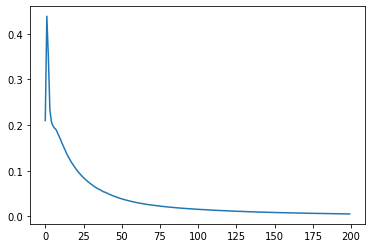

In [7]:
plt.plot(range(num_epochs), losses)

## Evaluation

In [12]:
y_pred = model.forward_pass(x_train.reshape(-1,1))
y_pred = y_pred.ravel()

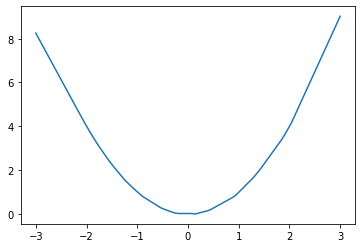

In [9]:
plt.plot(x_train, y_pred)

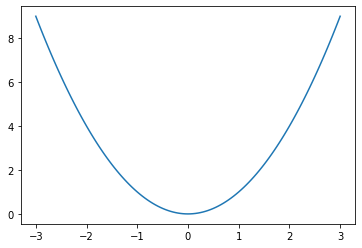

In [10]:
plt.plot(x_train, y_train)

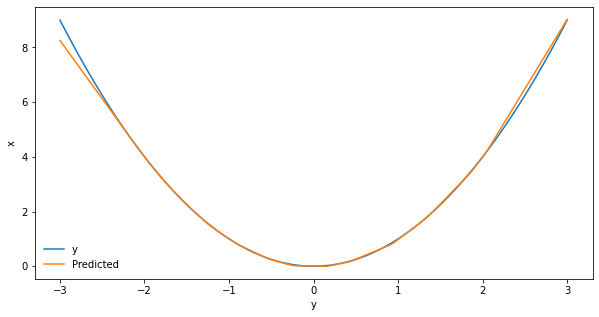

In [11]:
plt.figure(figsize=(10,5))
plt.plot(x_train, y_train, label='y')
plt.plot(x_train, y_pred, label='Predicted')
plt.xlabel("y")
plt.ylabel("x")
plt.legend(frameon=False)
plt.show()